<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>

<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">رگرسیون تخمین قیمت بر اساس تصویر خانه با شبکه های کانولوشنالی 
</div></center></h1>


# Keras, Regression, and CNNs

<ul>
    <li>Removing the fully-connected softmax classifier layer typically used for classification</li>
<li>Replacing it with a fully-connected layer with a single node along with a linear activation function.</li>
<li>Training the model with a continuous value prediction loss function such as mean squared error, mean absolute error, mean absolute percentage error, etc.</li>
</ul>

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">معرفی مجموعه داده تخممین قیمت منازل </div>

<div style="direction:rtl;text-align:right;font-family:Tahoma">
این مجموعه داده در مقاله سال 2016 تحت عنوان 2016
    House price estimation from visual and textual features
معرفی و منتشر شده است.
</div>
<p>
<a href="https://github.com/emanhamed/Houses-dataset" target="_blank">
https://github.com/emanhamed/Houses-dataset
</a>
<br>
<a href="https://arxiv.org/pdf/1609.08399.pdf" target="_blank">
https://arxiv.org/pdf/1609.08399.pdf
</a>
    
</p>

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import glob
import matplotlib.pyplot as plt
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


In [2]:
inputPath = "D:/dataset/Houses-dataset/Houses Dataset/HousesInfo.txt"
datasetPath = "D:/dataset/Houses-dataset/Houses Dataset"

cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)


zipcodes, counts = np.unique(df["zipcode"], return_counts=True)

# loop over each of the unique zip codes and their corresponding
# count
for (zipcode, count) in zip(zipcodes, counts):
    # the zip code counts for our housing dataset is *extremely*
    # unbalanced (some only having 1 or 2 houses per zip code)
    # so let's sanitize our data by removing any houses with less
    # than 25 houses per zip code
    if count < 25:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)

In [ ]:
# initialize our images array (i.e., the house images themselves)
images = []

# loop over the indexes of the houses
for i in df.index.values:
    # find the four images for the house and sort the file paths,
    # ensuring the four are always in the *same order*
    basePath = os.path.sep.join([datasetPath, "{}_*".format(i + 1)])
    housePaths = sorted(list(glob.glob(basePath)))
    # initialize our list of input images along with the output image
    # after *combining* the four input images
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")

    # loop over the input house paths
    for housePath in housePaths:
        # load the input image, resize it to be 32 32, and then
        # update the list of input images
        image = cv2.imread(housePath)
        image = cv2.resize(image, (32, 32))
        inputImages.append(image)

    # tile the four input images in the output image such the first
    # image goes in the top-right corner, the second image in the
    # top-left corner, the third image in the bottom-right corner,
    # and the final image in the bottom-left corner
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]

    # add the tiled image to our set of images the network will be
    # trained on
    images.append(outputImage)
images = np.array(images)

In [ ]:
images.shape

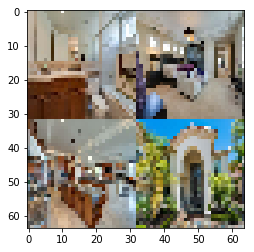

In [11]:
plt.imshow(images[37][...,::-1])

In [12]:
images = images / 255.0

In [13]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

In [14]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [16]:
from keras.models import Model, Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

width, height, depth = 64, 64, 3
filters=(16, 32, 64)
# initialize the input shape and channel dimension, assuming
# TensorFlow/channels-last ordering
inputShape = (height, width, depth)
chanDim = -1

# define the model input
inputs = Input(shape=inputShape)

# loop over the number of filters
for (i, f) in enumerate(filters):
    # if this is the first CONV layer then set the input
    # appropriately
    if i == 0:
        x = inputs

    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
# flatten the volume, then FC => RELU => BN => DROPOUT
x = Flatten()(x)
x = Dense(16)(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=chanDim)(x)
x = Dropout(0.5)(x)

# apply another FC layer, this one to match the number of nodes
# coming out of the MLP
x = Dense(4)(x)
x = Activation("relu")(x)


x = Dense(1, activation="linear")(x)

# construct the CNN
model = Model(inputs, x)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
__________

In [18]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [25]:
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY), 
          epochs=200, batch_size=8)

Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 2s 8ms/step - loss: 1941.2076 - val_loss: 1598.4589
Epoch 2/200
271/271 [==============================] - 1s 2ms/step - loss: 1349.4392 - val_loss: 1729.1964
Epoch 3/200
271/271 [==============================] - 1s 2ms/step - loss: 1041.9592 - val_loss: 1932.3454
Epoch 4/200
271/271 [==============================] - 1s 2ms/step - loss: 867.0342 - val_loss: 635.8037
Epoch 5/200
271/271 [==============================] - 1s 2ms/step - loss: 783.2866 - val_loss: 365.9065
Epoch 6/200
271/271 [==============================] - 1s 2ms/step - loss: 454.9674 - val_loss: 301.9118
Epoch 7/200
271/271 [==============================] - 1s 2ms/step - loss: 501.3928 - val_loss: 281.8461
Epoch 8/200
271/271 [==============================] - 1s 2ms/step - loss: 451.1617 - val_loss: 276.9117
Epoch 9/200
271/271 [==============================] - 1s 2ms/step - loss: 355.2670 - val_loss: 250.1414
Epoc

Epoch 79/200
271/271 [==============================] - 1s 2ms/step - loss: 55.0343 - val_loss: 61.6644
Epoch 80/200
271/271 [==============================] - 1s 2ms/step - loss: 51.7721 - val_loss: 61.4173
Epoch 81/200
271/271 [==============================] - 1s 2ms/step - loss: 52.7649 - val_loss: 60.3755
Epoch 82/200
271/271 [==============================] - 1s 2ms/step - loss: 48.5776 - val_loss: 60.1092
Epoch 83/200
271/271 [==============================] - 1s 2ms/step - loss: 49.7893 - val_loss: 59.4538
Epoch 84/200
271/271 [==============================] - 1s 2ms/step - loss: 55.1904 - val_loss: 59.1017
Epoch 85/200
271/271 [==============================] - 1s 2ms/step - loss: 47.6957 - val_loss: 59.8379
Epoch 86/200
271/271 [==============================] - 1s 2ms/step - loss: 48.6987 - val_loss: 59.6647
Epoch 87/200
271/271 [==============================] - 1s 2ms/step - loss: 52.5514 - val_loss: 59.4988
Epoch 88/200
271/271 [==============================] - 1s 2ms/s

<hr>

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">‌منبع</div>   

https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> دوره مقدماتی یادگیری عمیق<br>علیرضا اخوان پور<br>پنج شنبه، ۲۵ بهمن ۱۳۹۷<br>
</div>
<a href="http://class.vision">Class.Vision</a> - <a href="http://AkhavanPour.ir">AkhavanPour.ir</a> - <a href="https://github.com/Alireza-Akhavan/">GitHub</a>

</div>